### Comparing the performance the updated model trained using 100K segments by Adam with the older tensorflow model trained with 300K segments.


In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:

from sklearn.datasets import load_svmlight_file
from sklearn.externals import joblib
import argparse
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report

In [4]:
result = pd.read_csv('~/all_2k_prediction.out.label.prediction_combined',sep=' ',header=None,names=['name','length','probability','prediction','vfam','pfam','diamond','label',
                                                                                       'score_euk_non_euk','pred_euk_non_euk','score_non_euk_virus','pred_non_euk_virus',
                                                                                      'score_virus_non_virus','pred_virus_non_virus'])

In [8]:
### Using MEGAN annotation to check model performance 


from ete2 import NCBITaxa
ncbi = NCBITaxa()
def get_top_label(tax_id):
    lineage = ncbi.get_lineage(tax_id)
    for i in lineage:
        if i == 2759:
            return "Eukaryota"
        elif i == 10239:
            return "Virus"
        elif i == 2157:
            return "Archaea"
        elif i == 2:
            return "Bacteria"
        elif i == 12884:
            return "Viroids"
        elif i == 28384:
            return "other"
        elif i == 12908:
            return "unclassified"
    else:
        return "N/A"

def get_ranks(tax_id):
    ranks = ncbi.get_rank([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id
    
def get_name(tax_id):
    ranks = ncbi.get_taxid_translator([tax_id])
    try:
        return ranks.values()[0]
    except:
        return tax_id

# get MEGAN annotation results

megan_annot = pd.read_csv('./Micromonas/all_2k_contigs.fa.diamond-ex-all_tax_ID.txt',sep='\t',header=None,names=['name','tax_id'])

megan_annot['rank'] = megan_annot['tax_id'].apply(get_ranks)
megan_annot['tax_name']= megan_annot['tax_id'].apply(get_name)
megan_annot['top_label']= megan_annot['tax_id'].apply(get_top_label)


In [13]:
new_table = pd.merge(result,megan_annot, on=['name'])

In [16]:
prediction_300k = pd.read_csv('~/all_2k_contigs.fa.prediction.300k_full')

In [21]:
prediction_adam = pd.read_csv('/global/projectb/scratch/qpzhang/TARA/Libsvm/ViCA2/all_2k_contigs.fa.prediction.Adam')

In [23]:
prediction_adam_subset = prediction_adam[['ID','Prob_class_1']]

In [24]:
prediction_adam_subset.rename(index=str,columns={"ID": "name"},inplace=True)

In [25]:
prediction_adam_subset.rename(index=str,columns={"Prob_class_1": "adam_prediction"},inplace=True)



In [17]:
prediction_300k_subset = prediction_300k[['ID','Prob_class_1']]

In [18]:
prediction_300k_subset.rename(index=str,columns={"ID": "name"},inplace=True)

/global/homes/q/qpzhang/anaconda3/envs/jupyter2/lib/python2.7/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [19]:
prediction_300k_subset.rename(index=str,columns={"Prob_class_1": "300k_prediction"},inplace=True)

In [26]:
new_table_300k_joined = pd.merge(new_table,prediction_300k_subset, how='left',on=['name'])

In [27]:
new_table_300k_adam_joined = pd.merge(new_table_300k_joined,prediction_adam_subset, how='left',on=['name'])

### 7041 contigs as ground-truth virus-related, with hits to virus-related domains, or annotated as virus by MEGAN based on BlastX/Diamond alignment

### 208302 contigs with length >=2k, in TARA


In [35]:
new_table_300k_adam_joined["non_euk_label"] = (new_table_300k_adam_joined.top_label!='Eukaryota')

In [36]:
new_table_300k_adam_joined["micromonas_label"] = (new_table_300k_adam_joined.tax_name=='Micromonas') |(new_table_combined2.tax_name=='Micromonas pusilla CCMP1545')|(
        new_table_300k_adam_joined.tax_name=='Micromonas commoda')


#### "no rank" does not equal "no annotation"

In [33]:
def convert_top_label(top_label):
    if top_label == 'N/A':
        return 'no annotation'
    else:
        return 'with annotation'

In [38]:
new_table_300k_adam_joined['annotation_label'] = new_table_300k_adam_joined['top_label'].map(convert_top_label)

### Split the TARA contigs into 3 categories

- "Virus" has virus-related domain hits or annotated as "virus" by MEGAN
- "Non-virus" , no virus-related domain hits, annotated as some non-virus taxonomical group by MEGAN 
- "Unknown",  no virus-related domain hits, not annotated into any taxonomical group by MEGAN, top_label as "N/A"

#### subsample "non-virus" and "unknown" to have same number of "Virus" contigs - 6913

In [40]:
# "non-virus" data frame... non-virus and with annotation by MEGAN
df_nonvirus = new_table_300k_adam_joined[new_table_300k_adam_joined.label==0.0][new_table_300k_adam_joined['annotation_label']== 'with annotation']
df_nonvirus_subsample = df_nonvirus.sample(n=7041, replace=False)
#df_nonvirus_subsample.to_csv('df_nonvirus_subsample.csv')

# "Unknown" data frame... and without annotation by MEGAN

df_unknown = new_table_300k_adam_joined[new_table_300k_adam_joined.label==0.0][new_table_300k_adam_joined['annotation_label']== 'no annotation']
df_unknown_subsample = df_unknown.sample(n=7041, replace=False)
#df_unknown_subsample.to_csv('df_unknown_subsample.csv')

### "Virus" contigs...  has pfam hits or annotated as "virus" by MEGAN
df_virus = new_table_300k_adam_joined[new_table_300k_adam_joined.label==1.0]
#df_virus.to_csv('df_virus.csv')



/global/u2/q/qpzhang/anaconda3/envs/jupyter2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/global/u2/q/qpzhang/anaconda3/envs/jupyter2/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [42]:
def get_category(df):
    if df.label == 0.0:
        if df.annotation_label == 'with annotation':
            return 'nonvirus'
        else:
            return 'unknown'
    else:
        return 'virus'

In [43]:
new_table_300k_adam_joined['category'] = new_table_300k_adam_joined.apply(get_category, axis=1)

In [44]:
new_table_300k_adam_joined.groupby('category').describe()


300k_prediction                                              \
                   count      mean       std           min       25%   
category                                                               
nonvirus        190211.0  0.401566  0.366603  0.000000e+00  0.059232   
unknown          10947.0  0.524107  0.385863  4.059010e-16  0.121197   
virus             7041.0  0.912886  0.161966  2.169740e-04  0.909624   

                                  adam_prediction           ...      tax_id  \
               50%       75%  max           count      mean ...         75%   
category                                                    ...               
nonvirus  0.270205  0.776024  1.0        190211.0  0.374056 ...    296587.0   
unknown   0.514708  0.956122  1.0         10947.0  0.259086 ...    131567.0   
virus     0.982118  0.997370  1.0          7041.0  0.025109 ...   1407671.0   

                         vfam                                               
                max     count      mean       std  min  25%  50%  75%  max  
category                                                                    
nonvirus  1904754.0  190278.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
unknown    383630.0   10983.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  
virus     1880590.0    7041.0  0.014771  0.120642  0.0  0.0  0.0  0.0  1.0  

[3 rows x 136 columns]

In [46]:
df_micromonus = new_table_300k_adam_joined[new_table_300k_adam_joined.micromonas_label==True]

## Micromonus related contigs

### updated model with 100K segments by Adam

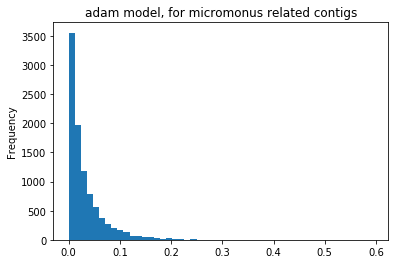

In [48]:
df_micromonus.adam_prediction.plot.hist(bins=50, title='adam model, for micromonus related contigs')

### Older model with 300K segments by QP

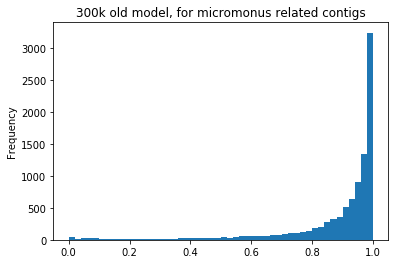

In [50]:
df_micromonus['300k_prediction'].plot.hist(bins=50, title='300k old model, for micromonus related contigs')

## All TARA contigs, with updated model  using 100K training segments

Text(0,0.5,'number of contigs')

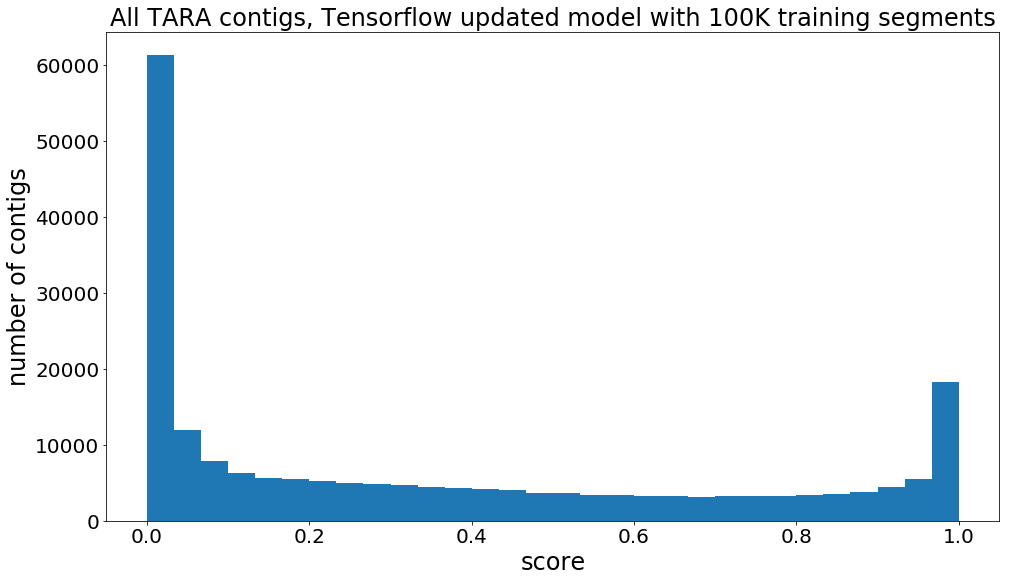

In [58]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 30
#colors = ['red', 'blue', 'grey']
x_multi = [new_table_300k_adam_joined[new_table_300k_adam_joined['adam_prediction']>0]['adam_prediction']]
ax0.hist(x_multi, n_bins, histtype='bar')
ax0.set_title('All TARA contigas, Tensorflow updated model with 100K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)



## "nonvirus" TARA contigs, with updated model using 100K training segments 

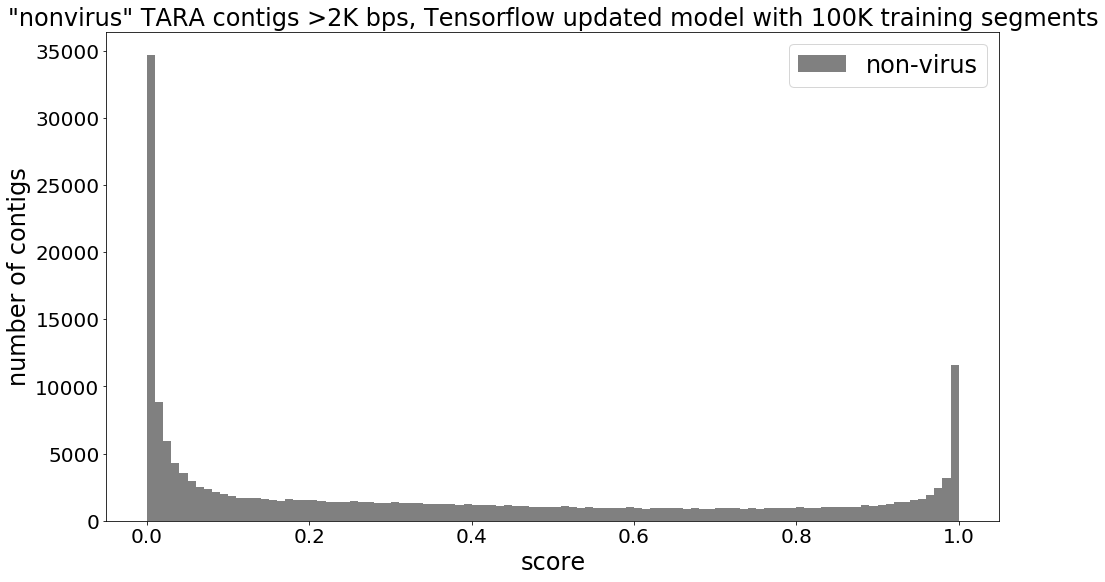

In [59]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 100
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus[df_nonvirus['adam_prediction']>0]['adam_prediction']]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'non-virus'],
         color=['grey'])
ax0.set_title('"nonvirus" TARA contigs >2K bps, Tensorflow updated model with 100K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

## "virus" TARA contigs, with updated model using 100K training segments 

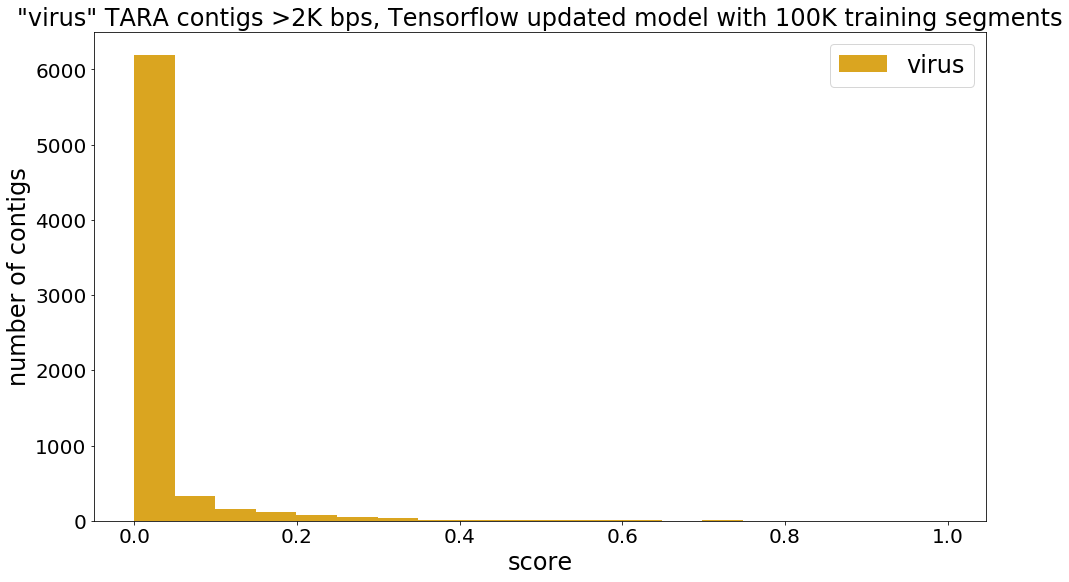

In [60]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 20
#colors = ['red', 'blue', 'grey']
x_multi = [df_virus[df_virus.adam_prediction>0].adam_prediction]
ax0.hist(x_multi, n_bins, histtype='bar',  label=[
                                                  'virus'],
         color=['goldenrod'])
ax0.set_title('"virus" TARA contigs >2K bps, Tensorflow updated model with 100K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

## Check the distribution of probability of same number of "virus", "non-virus", 'unknown" contigs

### Balanced data, same number of "virus" and "non-virus" contigs



/global/homes/q/qpzhang/anaconda3/envs/jupyter2/lib/python2.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/homes/q/qpzhang/anaconda3/envs/jupyter2/lib/python2.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


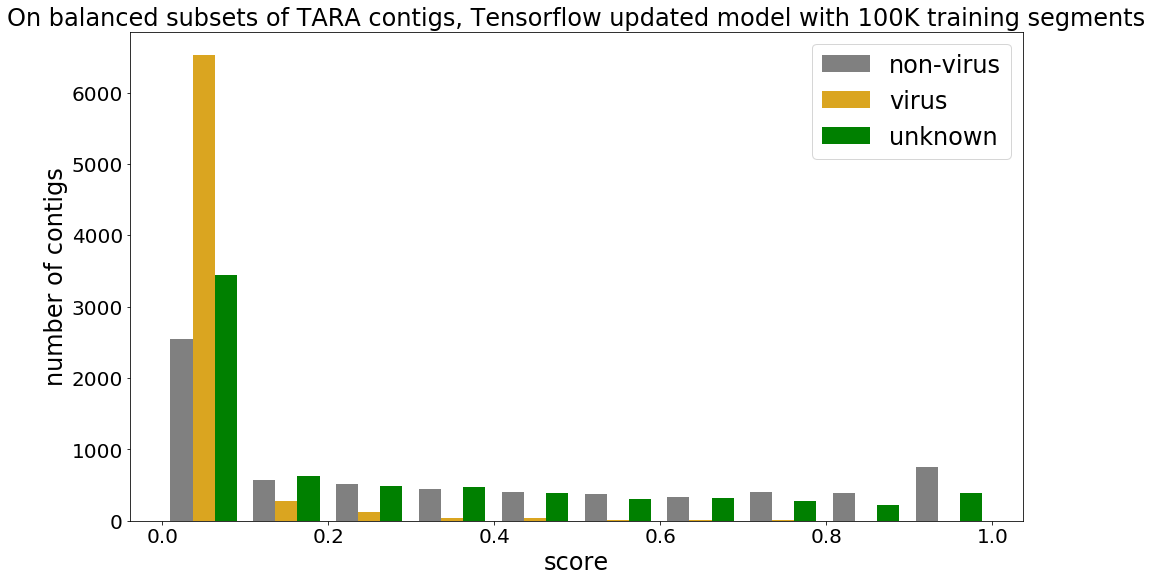

In [61]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample.adam_prediction,df_virus.adam_prediction, df_unknown_subsample.adam_prediction ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus','virus','unknown'],color=['grey', 'goldenrod', 'green'])
ax0.set_title('On balanced subsets of TARA contigs, Tensorflow updated model with 100K training segments',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.legend(prop={'size': 24})

## Balanced TARA contigs (same number of "virus" and "non-virus")

### comparing the updated model with 100K training segments and old model with 300K training segments

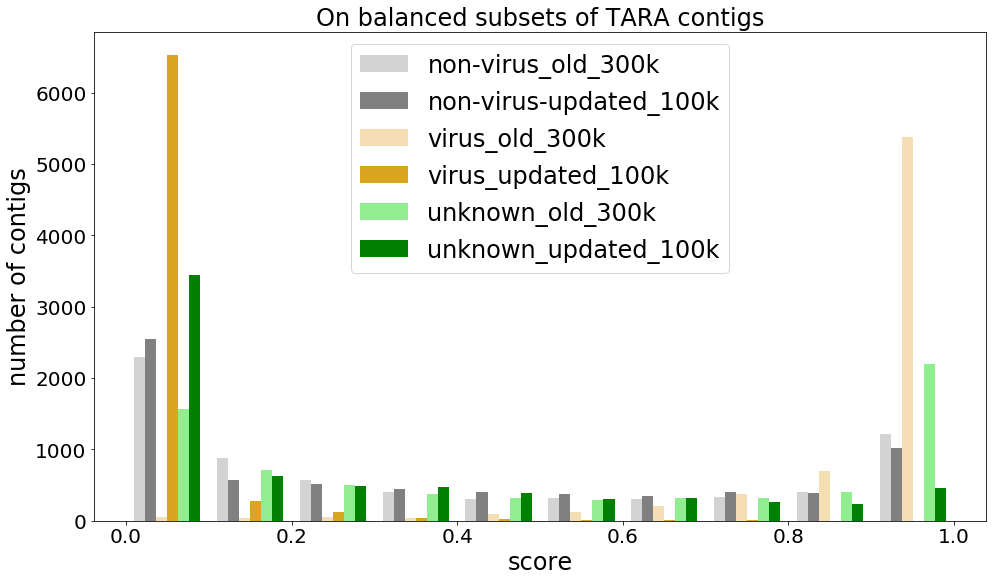

In [62]:
fig = plt.figure(figsize=(16,9))
ax0 = fig.add_subplot(111)
n_bins = 10
#colors = ['red', 'blue', 'grey']
x_multi = [df_nonvirus_subsample['300k_prediction'],df_nonvirus_subsample.adam_prediction,df_virus['300k_prediction'],
           df_virus.adam_prediction,df_unknown_subsample['300k_prediction'],df_unknown_subsample.adam_prediction ]
ax0.hist(x_multi, n_bins, histtype='bar',  label=['non-virus_old_300k','non-virus-updated_100k',
                                                  'virus_old_300k','virus_updated_100k',
                                                  'unknown_old_300k','unknown_updated_100k'],
         color=['lightgrey','grey', 'wheat','goldenrod', 'lightgreen','green'])
ax0.set_title('On balanced subsets of TARA contigs',fontsize=24)
ax0.set_xlabel('score',fontsize=24)
ax0.set_ylabel('number of contigs',fontsize=24)
ax0.tick_params(labelsize=20)
ax0.legend(prop={'size': 24})